#Intro

User Retention Prediction for Application Developers

* Problem Statement:

  * For application developers, a potential challenge for them would be the user retention. They need a realiable and reuseable method to simluate the retention rates of their users so that they can figure out which group of users are likely to be retained/churned. In this way, they can later on keep different users interested in their product by performing corresponidng retention task.

* Abstract:

  * Create a cloud hosted BigQuery machine learning model to determine the likelihood rates of users continue to use the app based on the user behaverior logs and user demographic information.

* Approach:

  * Pre-process the training data using user's demographic and behavioural logs. 
  * Train and evaluate machine learing models using BigQuery ML in GCP.
  * Make predictions using the terminative ML model.
  * Create project dashboard and perform visualization of the prediction results.

* Technology Stack:

  * Python, Bigquery(SQL), GCP

* Dataset:
  * In this application, we will be using a public dataset provided by GCP: an event based dataset which is generated by a real-world gaming mobile app called 'Flood-it!' that contains 5700000 event log infos from more than 15175 users.
  * Dataset format: Google Analytics 4 property data and the Google Analytics for Firebase data that is exported to BigQuery Export schema
  * Dataset URL: https://developers.google.com/analytics/bigquery/app-gaming-demo-dataset
  * Flood-it! App URL: https://flood-it.app/ 

* Persona:
  * Mobile Game developers who need to know the user retention rate and coresspoinding analytic data regarding their aplication. Knowing all these data would be significantly useful for them to form better targetd and customized user retention task on user in different retention categories.


#Environment Setup
Install packages and dependencies, and create a GCP project

In [ ]:
# run it if you haven't install GCS 
!pip install --upgrade google-cloud-storage

In [ ]:
# run it if you haven't install GCB
!pip install  google-cloud-bigquery

In [ ]:
# Automatically restart kernel after installs
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True) 

{'restart': True, 'status': 'ok'}

In [1]:
# Log in google cloud
!gcloud auth login

You are authorizing gcloud CLI without access to a web browser. Please run the following command on a machine with a web browser and copy its output back here. Make sure the installed gcloud version is 372.0.0 or newer.

gcloud auth login --remote-bootstrap="https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=32555940559.apps.googleusercontent.com&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&state=kV9oTuv3vPRMyZIHMPjCbkeEaBbzU2&access_type=offline&code_challenge=P5bahh1zXBQ1swGQPm-Mju2QdlN-L_Lc620kBI1QsCo&code_challenge_method=S256&token_usage=remote"


Enter the output of the above command: https://localhost:8085/?state=kV9oTuv3vPRMyZIHMPjCbkeEaBbzU2&code=4/0AX4XfWgsPAUTZH7Id5gxNH_HtR3844BhxoPXCFLHEtbX0Y2Mmy4P_hop97rhXibrE

In [2]:
# mount google drive
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [3]:
# configure the google application credentials: a json file generates by your GCP account
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/content/gdrive/My Drive/CMPE 272/cmpe-272-test.json"

In [4]:
# configure project name and region
PROJECT_ID = "cmpe-272-test"
REGION = 'US'

In [5]:
# set the configuration
!gcloud config set project $PROJECT_ID

Updated property [core/project].


In [6]:
# import dependencies
from google.cloud import bigquery
import pandas as pd

pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [7]:
# Check Google Cloud API authentication and credentials
def implicit():
    from google.cloud import storage

    # If you don't specify credentials when constructing the client, the
    # client library will look for credentials in the environment.
    storage_client = storage.Client()

    # Make an authenticated API request
    buckets = list(storage_client.list_buckets())
    print(buckets)

implicit()

[<Bucket: cmpe-272-test>]


#Data Preparation

##Data Acquisition

In [ ]:
# Bigquery initialization
DATASET_NAME = "bqmlga4"
!bq mk --location=$REGION --dataset $PROJECT_ID:$DATASET_NAME


Welcome to BigQuery! This script will walk you through the 
process of initializing your .bigqueryrc configuration file.

First, we need to set up your credentials if they do not 
already exist.

Setting project_id cmpe-272-test as the default.

BigQuery configuration complete! Type "bq" to get started.

BigQuery error in mk operation: Dataset 'cmpe-272-test:bqmlga4' already exists.


In [ ]:
%%bigquery --project $PROJECT_ID

CREATE OR REPLACE VIEW bqmlga4.original_dataset AS (

SELECT 
  *
FROM
  `firebase-public-project.analytics_153293282.events_*`
);

""


In [ ]:
%%bigquery --project $PROJECT_ID

SELECT
  *
FROM
  bqmlga4.original_dataset
LIMIT
  10

,event_date,event_timestamp,event_name,event_params,event_previous_timestamp,event_value_in_usd,event_bundle_sequence_id,event_server_timestamp_offset,user_id,user_pseudo_id,user_properties,user_first_touch_timestamp,user_ltv,device,geo,app_info,traffic_source,stream_id,platform,event_dimensions
0,20180713,1531539374336001,session_start,"[{'key': 'firebase_conversion', 'value': {'str...",1527597597494001,None,98,-103725286,None,9E635066BDD2E61E59252D382E0D2C61,"[{'key': 'initial_extra_steps', 'value': {'str...",1482918434034000,None,"{'category': 'tablet', 'mobile_brand_name': 'n...","{'continent': 'Americas', 'country': 'United S...","{'id': 'com.labpixies.flood', 'version': '2.62...",{'name': 'Mobile App | US | en | Mobile | Disp...,1051193346,ANDROID,None
1,20180713,1531539307624001,screen_view,"[{'key': 'firebase_previous_id', 'value': {'st...",1531539260849001,None,98,-103725286,None,9E635066BDD2E61E59252D382E0D2C61,"[{'key': 'initial_extra_steps', 'value': {'str...",1482918434034000,None,"{'category': 'tablet', 'mobile_brand_name': 'n...","{'continent': 'Americas', 'country': 'United S...","{'id': 'com.labpixies.flood', 'version': '2.62...",{'name': 'Mobile App | US | en | Mobile | Disp...,1051193346,ANDROID,None
2,20180713,1531539305918002,screen_view,"[{'key': 'firebase_previous_id', 'value': {'st...",1531539263624002,None,98,-103725286,None,9E635066BDD2E61E59252D382E0D2C61,"[{'key': 'initial_extra_steps', 'value': {'str...",1482918434034000,None,"{'category': 'tablet', 'mobile_brand_name': 'n...","{'continent': 'Americas', 'country': 'United S...","{'id': 'com.labpixies.flood', 'version': '2.62...",{'name': 'Mobile App | US | en | Mobile | Disp...,1051193346,ANDROID,None
3,20180713,1531539310595006,screen_view,"[{'key': 'firebase_previous_id', 'value': {'st...",1531539263918006,None,98,-103725286,None,9E635066BDD2E61E59252D382E0D2C61,"[{'key': 'initial_extra_steps', 'value': {'str...",1482918434034000,None,"{'category': 'tablet', 'mobile_brand_name': 'n...","{'continent': 'Americas', 'country': 'United S...","{'id': 'com.labpixies.flood', 'version': '2.62...",{'name': 'Mobile App | US | en | Mobile | Disp...,1051193346,ANDROID,None
4,20180713,1531539352717007,screen_view,"[{'key': 'firebase_previous_id', 'value': {'st...",1531539269595007,None,98,-103725286,None,9E635066BDD2E61E59252D382E0D2C61,"[{'key': 'initial_extra_steps', 'value': {'str...",1482918434034000,None,"{'category': 'tablet', 'mobile_brand_name': 'n...","{'continent': 'Americas', 'country': 'United S...","{'id': 'com.labpixies.flood', 'version': '2.62...",{'name': 'Mobile App | US | en | Mobile | Disp...,1051193346,ANDROID,None
5,20180713,1531539353439012,screen_view,"[{'key': 'firebase_previous_id', 'value': {'st...",1531539270717012,None,98,-103725286,None,9E635066BDD2E61E59252D382E0D2C61,"[{'key': 'initial_extra_steps', 'value': {'str...",1482918434034000,None,"{'category': 'tablet', 'mobile_brand_name': 'n...","{'continent': 'Americas', 'country': 'United S...","{'id': 'com.labpixies.flood', 'version': '2.62...",{'name': 'Mobile App | US | en | Mobile | Disp...,1051193346,ANDROID,None
6,20180713,1531539282930013,screen_view,"[{'key': 'firebase_previous_id', 'value': {'st...",1531539273439013,None,98,-103725286,None,9E635066BDD2E61E59252D382E0D2C61,"[{'key': 'initial_extra_steps', 'value': {'str...",1482918434034000,None,"{'category': 'tablet', 'mobile_brand_name': 'n...","{'continent': 'Americas', 'country': 'United S...","{'id': 'com.labpixies.flood', 'version': '2.62...",{'name': 'Mobile App | US | en | Mobile | Disp...,1051193346,ANDROID,None
7,20180713,1531539289854021,screen_view,"[{'key': 'firebase_previous_id', 'value': {'st...",1531539273930021,None,98,-103725286,None,9E635066BDD2E61E59252D382E0D2C61,"[{'key': 'initial_extra_steps', 'value': {'str...",1482918434034000,None,"{'category': 'tablet', 'mobile_brand_name': 'n...","{'continent': 'Americas', 'country': 'United S...","{'id': 'com.labpixies.flood', 'version': '2.62...",{'name': 'Mobil

In [ ]:
%%bigquery --project $PROJECT_ID

CREATE OR REPLACE VIEW bqmlga4.user_and_event_counts AS (
  SELECT 
      COUNT(DISTINCT user_pseudo_id) as count_distinct_users,
      COUNT(event_timestamp) as count_events
  FROM
    bqmlga4.original_dataset
);

""


In [ ]:
%%bigquery --project $PROJECT_ID

SELECT 
  * 
FROM 
  bqmlga4.user_and_event_counts

,count_distinct_users,count_events
0,15175,5700000


## Data Analysis and Preprosessing 

###Step 1: Identifying the label for each user

In [ ]:
%%bigquery --project $PROJECT_ID 

CREATE OR REPLACE VIEW bqmlga4.user_labling AS (
  WITH firstlasttouch AS (
    SELECT
      user_pseudo_id,
      MIN(event_timestamp) AS user_first_engagement,
      MAX(event_timestamp) AS user_last_engagement
    FROM
      bqmlga4.original_dataset
    WHERE event_name="user_engagement"
    GROUP BY
      user_pseudo_id

  )
  SELECT
    user_pseudo_id,
    user_first_engagement,
    user_last_engagement,
    EXTRACT(MONTH from TIMESTAMP_MICROS(user_first_engagement)) as month,
    EXTRACT(DAYOFYEAR from TIMESTAMP_MICROS(user_first_engagement)) as julianday,
    EXTRACT(DAYOFWEEK from TIMESTAMP_MICROS(user_first_engagement)) as dayofweek,

    #add 24 hr to user's first touch
    (user_first_engagement + 86400000000) AS ts_24hr_after_first_engagement,

#churned = 1 if last_touch within 24 hr of app installation, else 0
IF (user_last_engagement < (user_first_engagement + 86400000000),
    1,
    0 ) AS churned,

#bounced = 1 if last_touch within 5 min, else 0
IF (user_last_engagement <= (user_first_engagement + 300000000),
    1,
    0 ) AS bounced,
  FROM
    firstlasttouch
  GROUP BY
    1,2,3
    );

""


In [ ]:
%%bigquery --project $PROJECT_ID 

SELECT 
  * 
FROM 
  bqmlga4.user_labling 
LIMIT
  10

,user_pseudo_id,user_first_engagement,user_last_engagement,month,julianday,dayofweek,ts_24hr_after_first_engagement,churned,bounced
0,AF2C7C5196C8AC879E4BCDCAAF68D5E4,1529773758309000,1532128993098006,6,174,7,1529860158309000,0,0
1,5217AB1A454DAED6243E1C9818BE6A20,1529861523949001,1535405434229018,6,175,1,1529947923949001,0,0
2,BCEC642620FB741AA4EE43E0FC6C7A05,1530996288345008,1533609643397024,7,188,7,1531082688345008,0,0
3,920DB84FCC0F4421650B9E257E33180B,1528957982564003,1538313563840019,6,165,5,1529044382564003,0,0
4,01B3F8A4E745CED2639D0FBDC2FEFC88,1532142288940007,1532142364913001,7,202,7,1532228688940007,1,1
5,7DBEEB7A2488FE1FFC0808686AC09606,1531332824513008,1535367784934014,7,192,4,1531419224513008,0,0
6,4789C778386485B99F4077B97DFE34E3,1528931183521002,1537040908310004,6,164,4,1529017583521002,0,0
7,9B18A1CBA96D52D05CFA7CB7C9011EDE,1531098901503002,1536093337848003,7,190,2,1531185301503002,0,0
8,1A6F117EC48594AA7A7B3A42A605415A,1532133434700006,1532133547991011,7,202,7,1532219834700006,1,1
9,E512079B53179DF9A608CF4ADE47DE9D,1529351778192007,1538596335194016,6,169,2,1529438178192007,0,0


In [ ]:
%%bigquery --project $PROJECT_ID

CREATE OR REPLACE VIEW bqmlga4.user_bounced_and_churned AS (
SELECT
    bounced,
    churned, 
    COUNT(churned) as count_users
FROM
    bqmlga4.user_labling
GROUP BY 1,2
ORDER BY bounced
);

""


In [ ]:
%%bigquery --project $PROJECT_ID 

SELECT 
  * 
FROM 
  bqmlga4.user_bounced_and_churned  
  

,bounced,churned,count_users
0,0,0,6148
1,0,1,2777
2,1,1,4663


In [ ]:
%%bigquery --project $PROJECT_ID

CREATE OR REPLACE VIEW bqmlga4.user_bounced_and_churned_rate AS (

SELECT
    COUNTIF(churned=1)/COUNT(churned) as churn_rate,
    COUNTIF(bounced=1)/COUNT(bounced) as bounce_rate
FROM
    bqmlga4.user_labling
#WHERE bounced = 0
);

""


In [ ]:
%%bigquery --project $PROJECT_ID 

SELECT 
  * 
FROM 
  bqmlga4.user_bounced_and_churned_rate  

,churn_rate,bounce_rate
0,0.548,0.343


### Step 2. Extracting demographic data for each user

In [ ]:
%%bigquery --project $PROJECT_ID

CREATE OR REPLACE VIEW bqmlga4.user_demographics AS (

  WITH first_values AS (
      SELECT
          user_pseudo_id,
          geo.country as country,
          device.operating_system as operating_system,
          device.language as language,
          ROW_NUMBER() OVER (PARTITION BY user_pseudo_id ORDER BY event_timestamp DESC) AS row_num
      FROM bqmlga4.original_dataset
      WHERE event_name="user_engagement"
      )
  SELECT * EXCEPT (row_num)
  FROM first_values
  WHERE row_num = 1
  );

""


In [ ]:
%%bigquery --project $PROJECT_ID

SELECT
  *
FROM
  bqmlga4.user_demographics

,user_pseudo_id,country,operating_system,language
0,06DE385FB8FE1F9B3C866E5645866023,Norway,None,nb-no
1,096F51F57A27CD13F0FEB78BF778B50F,Uruguay,ANDROID,es-uy
2,1AD872561C6D6A28BA60CCA8F6376CD5,Guatemala,IOS,en-us
3,1CA5216B55152DE31E8C236E95CE7D50,South Korea,None,en-us
4,361F3570C32F1CE252B63BA587E7BDDC,Venezuela,ANDROID,es-es
...,...,...,...,...
13583,849938168F737FB0F6311F088956C871,United Kingdom,IOS,en-gb
13584,8DD47B40A0938BA8BD9FF0B34D83B28E,United Kingdom,IOS,en-gb
13585,CE141433511ABA7ED38F6C34445B91C7,United Kingdom,ANDROID,nl-nl
13586,E8205FDB6730D96FBA5804ADE5E6A1FA,United Kingdom,ANDROID,en-gb


### Step 3. Extracting behavioral data for each user

In [ ]:
%%bigquery --project $PROJECT_ID

CREATE OR REPLACE VIEW bqmlga4.user_behavioral_event_and_count AS (

SELECT
    event_name,
    COUNT(event_name) as event_count
FROM
    bqmlga4.original_dataset
GROUP BY 1
ORDER BY
   event_count DESC
);

""


In [ ]:
%%bigquery --project $PROJECT_ID

SELECT
  *
FROM
  bqmlga4.user_behavioral_event_and_count

,event_name,event_count
0,screen_view,2247623
1,user_engagement,1358958
2,level_start_quickplay,523430
3,level_end_quickplay,349729
4,post_score,242051
5,level_complete_quickplay,191088
6,level_fail_quickplay,137035
7,level_reset_quickplay,122278
8,select_content,105139
9,level_start,74417


### Step 4: Analyze the underlying relationship between the behavioral data and the churn rate

In [8]:
%%bigquery --project $PROJECT_ID

CREATE OR REPLACE VIEW bqmlga4.user_aggregate_behavior_neg AS (
WITH
  events_first24hr AS (
    #select user data only from first 24 hr of using the app
    SELECT
      e.*
    FROM
      bqmlga4.original_dataset e
    JOIN
      bqmlga4.user_labling r
    ON
      e.user_pseudo_id = r.user_pseudo_id
    WHERE
      e.event_timestamp <= r.ts_24hr_after_first_engagement
    )
SELECT
  user_pseudo_id,
  SUM(IF(event_name = 'screen_view', 1, 0)) AS cnt_screen_view,
  SUM(IF(event_name = 'user_engagement', 1, 0)) AS cnt_user_engagement,
  SUM(IF(event_name = 'level_start_quickplay', 1, 0)) AS cnt_level_start_quickplay,
  SUM(IF(event_name = 'level_end_quickplay', 1, 0)) AS cnt_level_end_quickplay,
  SUM(IF(event_name = 'post_score', 1, 0)) AS cnt_post_score,
  SUM(IF(event_name = 'level_complete_quickplay', 1, 0)) AS cnt_level_complete_quickplay,
  SUM(IF(event_name = 'level_fail_quickplay', 1, 0)) AS cnt_level_fail_quickplay,
  SUM(IF(event_name = 'level_reset_quickplay', 1, 0)) AS cnt_level_reset_quickplay,
  SUM(IF(event_name = 'select_content', 1, 0)) AS cnt_select_content,  
  SUM(IF(event_name = 'level_start', 1, 0)) AS cnt_level_start,
  SUM(IF(event_name = 'session_start', 1, 0)) AS cnt_session_start,  
  SUM(IF(event_name = 'level_end', 1, 0)) AS cnt_level_end,
  SUM(IF(event_name = 'level_retry', 1, 0)) AS cnt_level_retry,
  SUM(IF(event_name = 'level_up', 1, 0)) AS cnt_level_up,
  SUM(IF(event_name = 'level_complete', 1, 0)) AS cnt_level_complete,
  SUM(IF(event_name = 'level_retry_quickplay', 1, 0)) AS cnt_level_retry_quickplay,
  SUM(IF(event_name = 'level_fail', 1, 0)) AS cnt_level_fail,
  SUM(IF(event_name = 'spend_virtual_currency', 1, 0)) AS cnt_spend_virtual_currency,
  SUM(IF(event_name = 'use_extra_steps', 1, 0)) AS cnt_use_extra_steps,
  SUM(IF(event_name = 'level_reset', 1, 0)) AS cnt_level_reset,
  SUM(IF(event_name = 'app_exception', 1, 0)) AS cnt_app_exception,
  SUM(IF(event_name = 'no_more_extra_steps', 1, 0)) AS cnt_no_more_extra_steps,          
  SUM(IF(event_name = 'ad_reward', 1, 0)) AS cnt_ad_reward,
  SUM(IF(event_name = 'completed_5_levels', 1, 0)) AS cnt_completed_5_levels 
FROM
  events_first24hr
GROUP BY
  1
);

""


In [9]:
%%bigquery --project $PROJECT_ID

CREATE OR REPLACE VIEW bqmlga4.user_aggregate_behavior_new AS (

SELECT
  abn.user_pseudo_id,
  abn.* EXCEPT(user_pseudo_id),
  abp.* EXCEPT(user_pseudo_id),
  ( SELECT SUM(CAST(value AS INT64)) 
    FROM UNNEST(REGEXP_EXTRACT_ALL(TO_JSON_STRING(abn), r':(\d+),?')) value
  ) AS cnt_neg_operations,
  ( SELECT SUM(CAST(value AS INT64)) 
    FROM UNNEST(REGEXP_EXTRACT_ALL(TO_JSON_STRING(abp), r':(\d+),?')) value
  ) AS cnt_pos_operations,

FROM
  bqmlga4.user_aggregate_behavior_neg abn
LEFT OUTER JOIN
  bqmlga4.user_aggregate_behavior_pos abp
ON 
  abn.user_pseudo_id = abp.user_pseudo_id
);

""


In [10]:
%%bigquery --project $PROJECT_ID

SELECT
  *
FROM
  bqmlga4.user_aggregate_behavior_new
LIMIT
  10

,user_pseudo_id,cnt_screen_view,cnt_user_engagement,cnt_level_start_quickplay,cnt_level_end_quickplay,cnt_post_score,cnt_level_complete_quickplay,cnt_level_fail_quickplay,cnt_level_reset_quickplay,cnt_select_content,...,cnt_firebase_campaign,cnt_first_open,cnt_os_update,cnt_app_remove,cnt_app_update,cnt_error,cnt_challenge_a_friend,cnt_in_app_purchase,cnt_neg_operations,cnt_pos_operations
0,6A2F4E7AB1816D2F6EC741BC92141766,236,168,48,31,16,13,18,9,21,...,2,1,0,0,0,0,1,0,605,4
1,7BCFAF1D468E309D866E9FEA7795FF85,20,13,1,0,3,0,0,0,3,...,0,0,0,0,0,0,0,0,57,0
2,171871CA6AF9A891FB7B3E19CD144B2E,118,75,1,0,10,0,0,0,17,...,2,1,0,1,0,0,0,0,301,4
3,43B8EEA09D7D62EC90F40D0E3716E960,28,20,0,0,2,0,0,0,2,...,2,1,0,0,0,0,0,0,72,3
4,7C7C8524146AA5006BE260A041101DF3,4,4,0,0,0,0,0,0,0,...,2,1,0,1,0,0,0,0,8,4
5,C59286E780962666D2A9C13A478542C8,4,4,0,0,0,0,0,0,0,...,2,1,0,1,0,0,0,0,8,4
6,7CB9FDA17938289CE3019602888EEC58,2,2,0,0,0,0,0,0,0,...,2,1,0,0,0,0,0,0,4,3
7,67E34D40DA8EB486DC847509A97762DA,13,9,5,1,0,0,1,3,1,...,0,0,1,0,0,0,0,0,35,1
8,6A99D4E5FE96E6BAA99D7A52932F7E15,379,258,3,2,94,2,0,0,10,...,2,1,0,0,0,0,0,0,1254,3
9,E156684FAFCEDF58457F297C0E8F4BE5,30,19,1,0,3,0,0,0,5,...,0,0,1,0,0,0,0,0,80,1


In [11]:
%%bigquery --project $PROJECT_ID

CREATE OR REPLACE VIEW bqmlga4.user_behavioral_dataset AS (

SELECT
  abn.*,
  lab.churned
FROM
  bqmlga4.user_aggregate_behavior_new abn
LEFT OUTER JOIN
  bqmlga4.user_labling lab
ON 
  abn.user_pseudo_id = lab.user_pseudo_id
);

""


In [12]:
from google.cloud import bigquery
client = bigquery.Client()

sql = """
    SELECT
      *
    FROM 
      bqmlga4.user_behavioral_dataset
"""

df = client.query(sql).to_dataframe()

In [13]:
df

,user_pseudo_id,cnt_screen_view,cnt_user_engagement,cnt_level_start_quickplay,cnt_level_end_quickplay,cnt_post_score,cnt_level_complete_quickplay,cnt_level_fail_quickplay,cnt_level_reset_quickplay,cnt_select_content,...,cnt_first_open,cnt_os_update,cnt_app_remove,cnt_app_update,cnt_error,cnt_challenge_a_friend,cnt_in_app_purchase,cnt_neg_operations,cnt_pos_operations,churned
0,14C332A3E8F90106FE94D91E11EF8774,6,3,6,0,0,0,0,5,1,...,0,0,0,0,0,0,0,22,0,1
1,9B7280F969D2C28482C07B24BD405529,25,16,4,3,1,1,2,0,1,...,1,0,0,0,0,0,0,58,3,0
2,8B7FACC2862766EC0B3251F781D46F4D,51,15,3,1,0,0,1,0,8,...,0,0,0,1,0,0,0,97,1,1
3,0FF8564C8A8D00C240B915776E574152,10,7,2,1,1,1,0,0,1,...,0,1,0,1,0,0,0,24,2,0
4,952D6D7F72A4002431E8D37519365AE4,18,9,1,1,1,1,0,0,1,...,0,0,0,0,0,0,0,39,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13583,99C20F2D20C197C5E106DE31C5B48277,39,13,4,4,1,1,3,0,4,...,0,0,0,0,0,0,0,73,0,0
13584,8382BEBD5B259592C23D9AF35F0B357F,21,9,5,5,5,5,0,0,1,...,0,0,0,0,0,0,0,52,0,0
13585,4514AE17591D9C14A67FE865E36C3860,12,5,3,2,2,2,0,0,1,...,0,0,0,0,0,0,0,28,0,1
13586,83988F0CA26C505E5E501A2F454F0942,7,4,2,1,1,1,0,0,1,...,0,1,0,1,0,0,0,18,2,1


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns

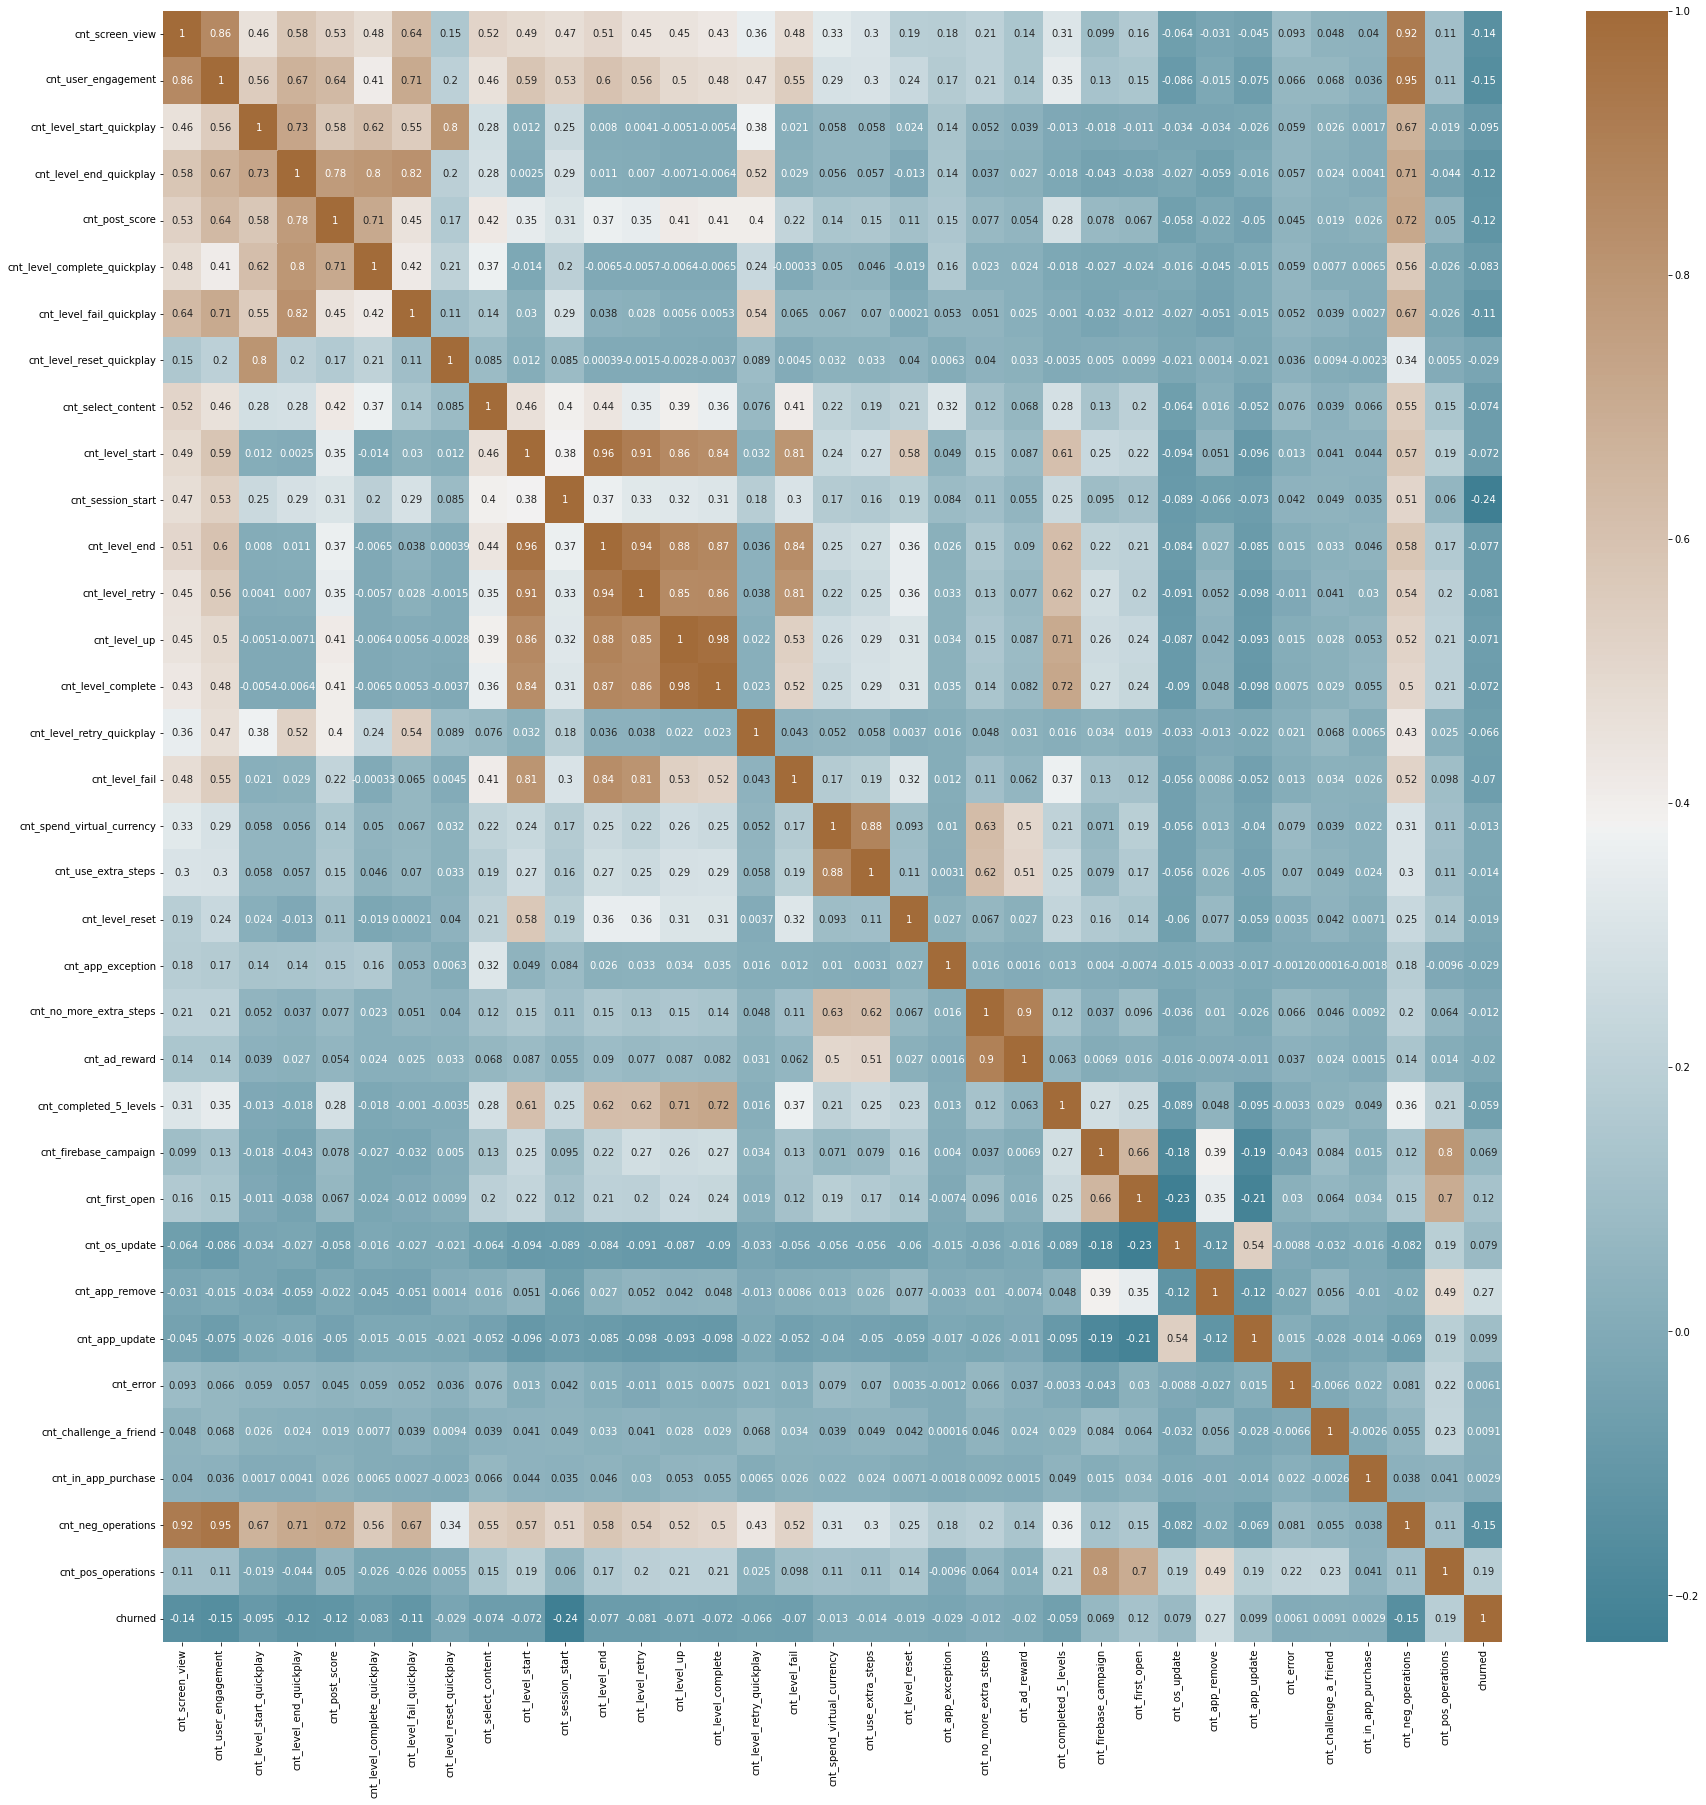

In [15]:
corr = df.corr()# plot the heatmap
fig, ax = plt.subplots(figsize=(30, 30))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(220, 40, as_cmap=True))

### Step 5: Combining the label, demographic and behavioral data together as training data

# Model Training (using BigQuery ML)

# Model Evaluation

# Model Prediction

# Data Visualization